In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb

In [ ]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

ntrain = train.shape[0]
ntest = test.shape[0]

print(ntrain, 'samples in train')
print(ntest, 'samples in test')

In [ ]:
train.head()

Dataset description:  
121 variables in train and test sets.  
  
- SK_ID_CURR: id of loan
- TARGET: Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

In [ ]:
def convert_types(df, print_info=False):
    original_memory = df.memory_usage().sum()
    
    for col in df:
        # ids to int32
        if ('ID' in col):
            df[col] = df[col].astype(np.int32)
        
        # object to category
        elif (df[col].dtype == 'object') and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype('category')
            
        elif list(df[col].unique()) == [1,0] or list(df[col].unique()) == [0,1]:
            df[col] = df[col].astype(bool)
            
        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)
            
        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)
            
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print('Original memory usage: %.2f MB' % (original_memory/1e6))
        print('New memory usage: %.2f MB' % (new_memory/1e6))
    
    return df            

In [ ]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if str(df[col].dtype) == 'category']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
train = convert_types(train, print_info=True)
test = convert_types(test, print_info=True)
df = pd.concat([train, test], axis=0)
del train, test

df['CODE_GENDER'].replace('XNA', np.nan, inplace= True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

In [ ]:
# client features
df['DAYS_EMPLOYED_RT'] = (df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']).astype(np.float32)
df['INCOME_PER_PERSON'] = (df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']).astype(np.float32)

In [ ]:
# loan features
df['CREDIT_GOODSPRICE_RT'] = (df['AMT_CREDIT']/df['AMT_GOODS_PRICE']).astype(np.float32)
df['CREDIT_INCOME_RT'] = (df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']).astype(np.float32)
df['ANNUITY_INCOME_RT'] = (df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']).astype(np.float32)
df['DURATION'] = (df['AMT_CREDIT'] / df['AMT_ANNUITY']).astype(np.float32) #normalize?

In [ ]:
df, df_cat_cols = one_hot_encoder(df, nan_as_category=True)
df = convert_types(df, print_info=True)

## Feature engineering: adding features of clients' previous loans
Home Credit collects data of:
- Clients' previous loans at Home Credit (HC). Products include POS cash, credit card and installments. 
- Clients' previous loans at credit bureau.

### Client previous loans at HC

#### previous.csv    
Previous loan applications at HC.

In [ ]:
prev = pd.read_csv('previous_application.csv')
prev = convert_types(prev, print_info=True)

prev.head()

In [ ]:
prev['NFLAG_LAST_APPL_IN_DAY'] = prev['NFLAG_LAST_APPL_IN_DAY'].astype('str')
prev['FLAG_LAST_APPL_PER_CONTRACT'] = prev['FLAG_LAST_APPL_PER_CONTRACT'].astype('str')

is_true = (prev['FLAG_LAST_APPL_PER_CONTRACT']=='Y') & (prev['NFLAG_LAST_APPL_IN_DAY'] == 'True')
prev = prev[is_true]

prev.drop(['FLAG_LAST_APPL_PER_CONTRACT', 
           'NFLAG_LAST_APPL_IN_DAY'], axis=1, inplace=True)

In [ ]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [ ]:
#loan features
prev['APP_CREDIT_RT'] = (prev['AMT_APPLICATION'] / prev['AMT_CREDIT']).astype(np.float32)
prev['CREDIT_GOODSPRICE_RT'] = (prev['AMT_CREDIT']/prev['AMT_GOODS_PRICE']).astype(np.float32)
prev['DURATION'] = (prev['AMT_CREDIT'] / prev['AMT_ANNUITY']).astype(np.float32)

In [ ]:
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

In [ ]:
agg_prev_num = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_RT': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'CREDIT_GOODSPRICE_RT': ['min', 'max', 'mean', 'var'],
    'DURATION': ['min', 'max', 'mean', 'var'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum']
}

agg_prev_cat = {}
for cat in cat_cols:
    agg_prev_cat[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**agg_prev_num, **agg_prev_cat})

prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])


In [ ]:
# Previous Applications: Approved Applications - numeric features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(agg_prev_num)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - numeric features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(agg_prev_num)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.merge(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev

prev_agg = convert_types(prev_agg, print_info=True)

#### Clients' previous payments
There are 3 datasets (for 3 loan products of HC) tracking clients previous repayments:
- POS CASH
- installments
- credit card  
  
Features indicating client paying habits which may be created from these datasets:  
- default days (max, sum, mean)
- default amount (max, sum, mean)
- default rate
- number of ongoing loans (only POS_CASH)
- number of loans  

#### POS_CASH_balance.csv

In [ ]:
pc = pd.read_csv('POS_CASH_balance.csv')
pc = convert_types(pc, print_info=True)
pc.head()

In [ ]:
pc, cat_cols = one_hot_encoder(pc, nan_as_category= True)

In [ ]:
#FLAG_DEFAULT: to calculate default rate
is_default = pc[(pc['SK_DPD']>0) | (pc['SK_DPD_DEF']>0)]
is_default['FLAG_DEFAULT'] = 1

tmp = is_default[['SK_ID_PREV', 'FLAG_DEFAULT']]
pc = pc.merge(tmp, on='SK_ID_PREV', how='left')
pc['FLAG_DEFAULT'] = pc['FLAG_DEFAULT'].fillna(0)

In [ ]:
agg_pc = {
    'SK_DPD': ['sum', 'max', 'mean'],
    'SK_DPD_DEF': ['sum', 'max', 'mean'],
    'FLAG_DEFAULT': ['sum', 'mean']
}

for cat in cat_cols:
    agg_pc[cat] = ['mean']

pc_agg = pc.groupby('SK_ID_CURR').agg(agg_pc)
pc_agg.columns = pd.Index(['PC_' + e[0] + "_" + e[1].upper() for e in pc_agg.columns.tolist()])


In [ ]:
# POS_CASH loan count
pc_agg['PC_CNT'] = pc.groupby('SK_ID_CURR').size().astype(np.int32)

In [ ]:
# ongoing POS-CASH loans
d = {}
for row in pc.itertuples():
    if (row.MONTHS_BALANCE == -1) and (row.NAME_CONTRACT_STATUS_Active == 1):
        d[row.SK_ID_CURR] = 1 + d.get(row.SK_ID_CURR, 0)

cnt = pd.DataFrame.from_dict(d, orient='index')

cnt.reset_index(inplace=True)
cnt.columns = ['SK_ID_CURR', 'PC_ONGOING_CNT']

pc_agg = pc_agg.merge(cnt, on='SK_ID_CURR', how='left')
pc_agg = convert_types(pc_agg, print_info=True)

del cnt, pc, d

#### credit_card_balance.csv

In [ ]:
cc = pd.read_csv('credit_card_balance.csv')
cc = convert_types(cc, print_info=True)

cc.head()

In [ ]:
#FLAG_DEFAULT: to calculate default rate
is_default = cc[(cc['SK_DPD']>0) | (cc['SK_DPD_DEF']>0)]
is_default['FLAG_DEFAULT'] = 1
# default amount: should be positive number
is_default['DEF_AMT'] = (is_default['AMT_INST_MIN_REGULARITY'] - is_default['AMT_PAYMENT_CURRENT']).astype(np.float32)
is_default['DEF_AMT'].apply(lambda x: x if x>0 else 0)
# payment ratio: should be < 1
is_default['PAYMENT_RT'] = (is_default['AMT_PAYMENT_CURRENT'] / is_default['AMT_INST_MIN_REGULARITY']).astype(np.float32)
is_default['PAYMENT_RT'].apply(lambda x: x if x<1 else 1)

tmp = is_default[['SK_ID_PREV', 'FLAG_DEFAULT', 'DEF_AMT', 'PAYMENT_RT']]
cc = cc.merge(tmp, on='SK_ID_PREV', how='left')
cc['FLAG_DEFAULT'] = cc['FLAG_DEFAULT'].fillna(0)

In [ ]:
agg_cc = {    
    'AMT_DRAWINGS_ATM_CURRENT': ['sum', 'max', 'mean', 'var'],
    'AMT_DRAWINGS_CURRENT': ['sum', 'max', 'mean', 'var'],
    'AMT_DRAWINGS_POS_CURRENT': ['sum', 'max', 'mean', 'var'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['sum', 'max', 'mean', 'var'],
    'SK_DPD': ['sum', 'max', 'mean'],
    'SK_DPD_DEF': ['sum', 'max', 'mean'],
    'DEF_AMT': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_RT': ['min', 'max', 'mean', 'var'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean', 'sum'],
    'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum'],
    'FLAG_DEFAULT': ['sum', 'mean']
}

cc_agg = cc.groupby('SK_ID_CURR').agg(agg_cc)
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# credit card loan count
cc_agg['CC_CNT'] = cc.groupby('SK_ID_CURR').size().astype(np.int32)
cc_agg = convert_types(cc_agg, print_info=True)

del cc

#### installments_payments.csv

In [ ]:
ins = pd.read_csv('installments_payments.csv')
ins = convert_types(ins, print_info=True)

ins.head()

In [ ]:
# Days past due: a client's default days
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0).astype(np.int32)

# Days before due: if a client is proactively repaying his debt
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0).astype(np.int32)

In [ ]:
is_default = ins[ins['DPD']>0]
is_default['FLAG_DEFAULT'] = 1

#default amount & payment ratio: amount a client fails to repay, and to what extent he fulfill the min payment
is_default['DEF_AMT'] = (ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']).astype(np.float32)
is_default['DEF_AMT'].apply(lambda x: x if x > 0 else 0)
is_default['PAYMENT_RT'] = (ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']).astype(np.float32)
is_default['PAYMENT_RT'].apply(lambda x: x if x < 1 else 1)

tmp = is_default[['SK_ID_PREV', 'FLAG_DEFAULT', 'DEF_AMT', 'PAYMENT_RT']]
ins = ins.merge(tmp, on='SK_ID_PREV', how='left')
ins['FLAG_DEFAULT'] = ins['FLAG_DEFAULT'].fillna(0)

In [ ]:
agg_ins = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['sum', 'max', 'mean'],
    'DBD': ['sum', 'max', 'mean'],
    'DEF_AMT': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_RT': ['min', 'max', 'mean', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'FLAG_DEFAULT': ['sum', 'mean']
}

for cat in cat_cols:
    agg_ins[cat] = ['mean']

ins_agg = ins.groupby('SK_ID_CURR').agg(agg_ins)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

ins_agg['INS_CNT'] = ins.groupby('SK_ID_CURR').size().astype(np.int32)
ins_agg = convert_types(ins_agg, print_info=True)

del ins

### Clients' previous loans at credit bureau 

In [ ]:
bureau = pd.read_csv('bureau.csv')
bureau = convert_types(bureau, print_info=True)

bureau.head()

In [ ]:
bb = pd.read_csv('bureau_balance.csv')
bb = convert_types(bb, print_info=True)

bb.head()

In [ ]:
bb['STATUS'].replace('X', np.nan, inplace=True)

is_default = bb[(bb['STATUS'] != 'C') & (bb['STATUS'] != '0')]
is_default['FLAG_DEFAULT'] = 1

In [ ]:
tmp = is_default[['SK_ID_BUREAU', 'FLAG_DEFAULT']]

bureau = bureau.merge(tmp, on='SK_ID_BUREAU', how='left')
bureau['FLAG_DEFAULT'] = bureau['FLAG_DEFAULT'].fillna(0)

In [ ]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

In [ ]:
agg_bb = {}
for col in bb_cat:
    agg_bb[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(agg_bb)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

bureau = bureau.merge(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)


In [ ]:
agg_num_bureau = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'FLAG_DEFAULT': ['sum', 'mean']
    }

agg_cat_bureau = {}
for cat in bureau_cat: agg_cat_bureau[cat] = ['mean']
for cat in bb_cat: agg_cat_bureau[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**agg_num_bureau, **agg_cat_bureau})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


In [ ]:
# Bureau: Active credits
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(agg_num_bureau)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg

# Bureau: Closed credits
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(agg_num_bureau)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau

del bb, bb_agg

bureau_agg = convert_types(bureau_agg, print_info=True)

## Constructing train and test sets

In [ ]:
df = df.merge(prev_agg, how='left', on='SK_ID_CURR')
df = df.merge(pc_agg, how='left', on='SK_ID_CURR')
df = df.merge(cc_agg, how='left', on='SK_ID_CURR')
df = df.merge(ins_agg, how='left', on='SK_ID_CURR')
df = df.merge(bureau_agg, how='left', on='SK_ID_CURR')

del prev_agg, pc_agg, cc_agg, ins_agg, bureau_agg

In [ ]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
target = train['TARGET'].copy().astype(np.int8)

test.drop(['TARGET'], axis=1, inplace=True)
train.drop(['TARGET'], axis=1, inplace=True)

## Modeling

In [438]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

NFOLDS = 5
ntrain = train.shape[0]
ntest = test.shape[0]

skfolder = StratifiedKFold(5, random_state=666, shuffle=True)
skf = skfolder.split(train, target)

def get_oof_lgb(clf, x_train, y_train, x_test, features, display=True):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    feature_importance_df = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(skf):
        print('Fold %d'% i)
        x_tr_oof = x_train.iloc[train_index]
        y_tr_oof = y_train.iloc[train_index]
        x_te_oof = x_train.iloc[test_index]
        y_te_oof = y_train.iloc[test_index]
        
        clf.fit(x_tr_oof, y_tr_oof, 
                eval_set=[(x_te_oof, y_te_oof)], 
                eval_metric='auc', 
                early_stopping_rounds=early_stopping, 
                verbose=100)
        
        if clf.best_iteration_ is None:
            oof_train[test_index] = clf.predict_proba(x_te_oof)[:,1]
            oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]
        else: 
            oof_train[test_index] = clf.predict_proba(x_te_oof, num_iteration=clf.best_iteration_)[:,1]
            oof_test_skf[i, :] = clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:,1]
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    if display:
        display_importances(feature_importance_df)
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), feature_importance_df

def display_importances(df):
    cols = df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:50].index
    best_features = df.loc[df.feature.isin(cols)]
    plt.figure(figsize=(9,20))
    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.tight_layout()
    plt.show()

#### Model 1: LightGBM trained with all features

In [ ]:
feats = [f for f in train.columns 
         if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
#705 features

In [ ]:
lgb1_params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'num_leaves': 34,
    'colsample_bytree':0.9497036,
    'subsample': 0.8715623,
    'max_depth': 8,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
}

early_stopping=200
ROUNDS=1500

lgb1_oof = lgb.LGBMClassifier(**lgb1_params, num_boost_round=ROUNDS)
lgb1_oof_train, lgb1_oof_test, lgb1_imp = get_oof_lgb(lgb1_oof, train[feats], target, test[feats], feats, display=True)

l1_train = pd.DataFrame(lgb1_oof_train, columns=['lgb1_oof_train'])
l1_test = pd.DataFrame(lgb1_oof_test, columns=['lgb1_oof_test'])

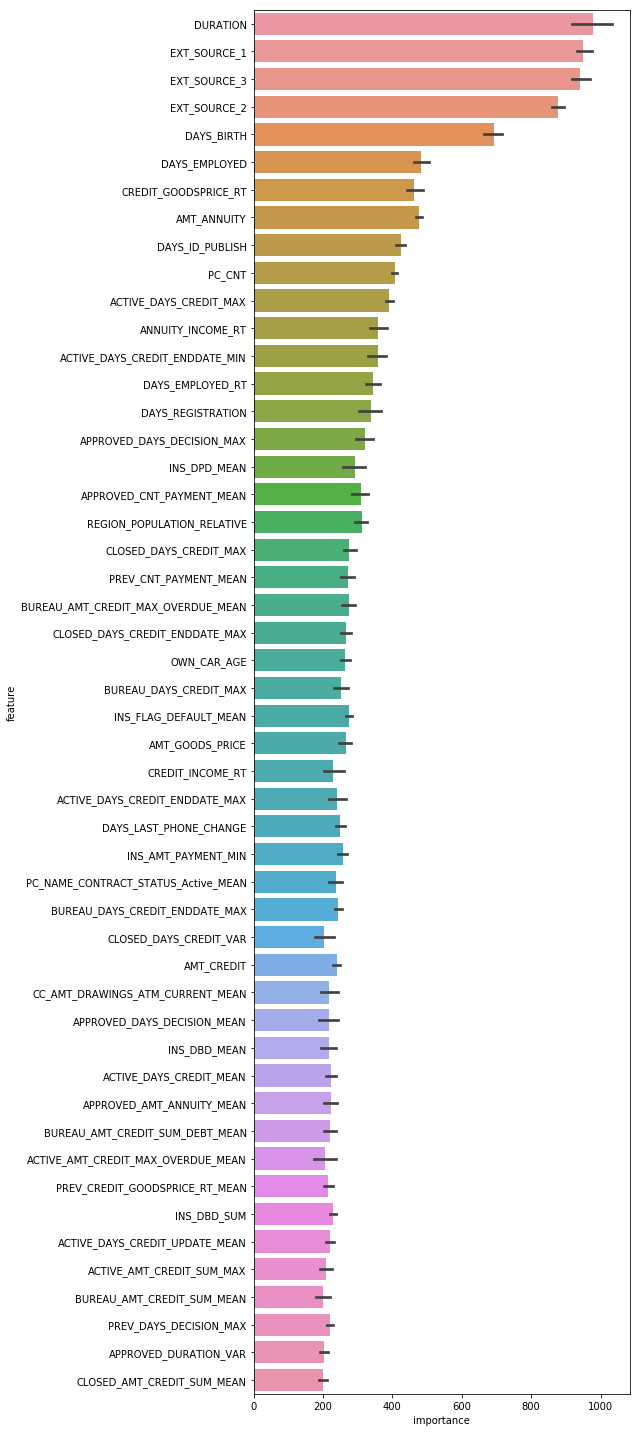

In [449]:
display_importances(lgb1_imp)

#### Model 2: LightGBM trained with selected features

In [ ]:
# Removing collinear variables with a correlation coefficient > 0.95
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

def remove_colinear_features(threshold, old_features):
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print('%d features have a correlation coefficient greater than %.2f' % (len(to_drop), threshold))
    new_features = list(set(old_features)-set(to_drop))
    return new_features, to_drop

feats_3, todrop_3 = remove_colinear_features(0.95, feats)

In [ ]:
ROUNDS=2000
lgb2_oof = lgb.LGBMClassifier(**lgb1_params, num_boost_round=ROUNDS)
lgb2_oof_train, lgb2_oof_test, lgb2_imp = get_oof_lgb(lgb2_oof, 
                                                      train[feats_3], target, test[feats_3], feats_3, display=True)

l1_train = pd.concat([l1_train, 
                      pd.DataFrame(lgb2_oof_train, columns=['lgb2_oof_train'])], 
                     axis=1)
l1_test = pd.concat([l1_test, 
                     pd.DataFrame(lgb2_oof_test, columns=['lgb2_oof_test'])],
                    axis=1)

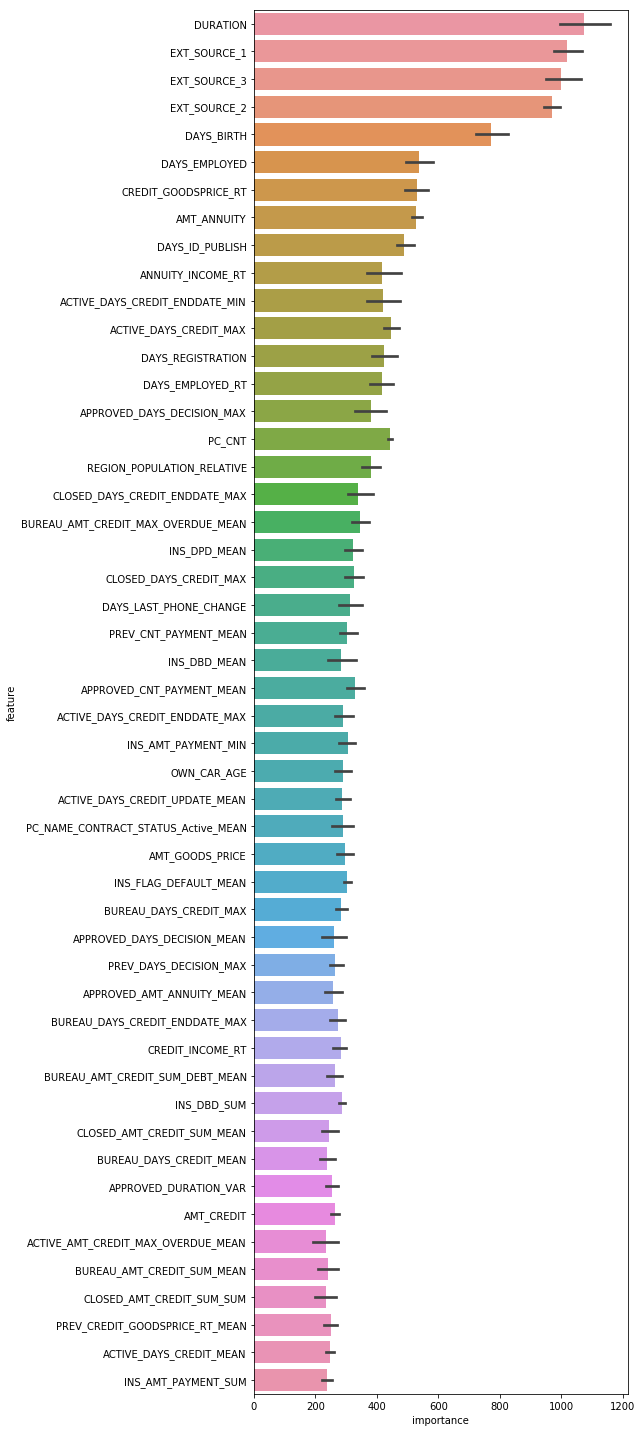

In [450]:
display_importances(lgb2_imp)

#### Model 3: LightGBM trained with different hyperparameters

In [ ]:
lgb_params_2={
    'colsample_bytree': 0.8075765874295522,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'subsample': 0.9823512122879835,
    'max_depth': 9,
    'reg_alpha': 0.04034934450418688,
    'reg_lambda': 0.07049671124205086,
    'min_split_gain': 0.027636837811357423,
    'min_child_weight': 39.81522946509787
}

ROUNDS = 2500

lgb3_oof = lgb.LGBMClassifier(**lgb_params_2, num_boost_round=ROUNDS)
lgb3_oof_train, lgb3_oof_test, lgb3_imp = get_oof_lgb(lgb3_oof, 
                                                      train[feats_3], target, test[feats_3], feats_3, display=True)

l1_train = pd.concat([l1_train, 
                      pd.DataFrame(lgb3_oof_train, columns=['lgb3_oof_train'])], 
                     axis=1)
l1_test = pd.concat([l1_test, 
                     pd.DataFrame(lgb3_oof_test, columns=['lgb3_oof_test'])],
                    axis=1)

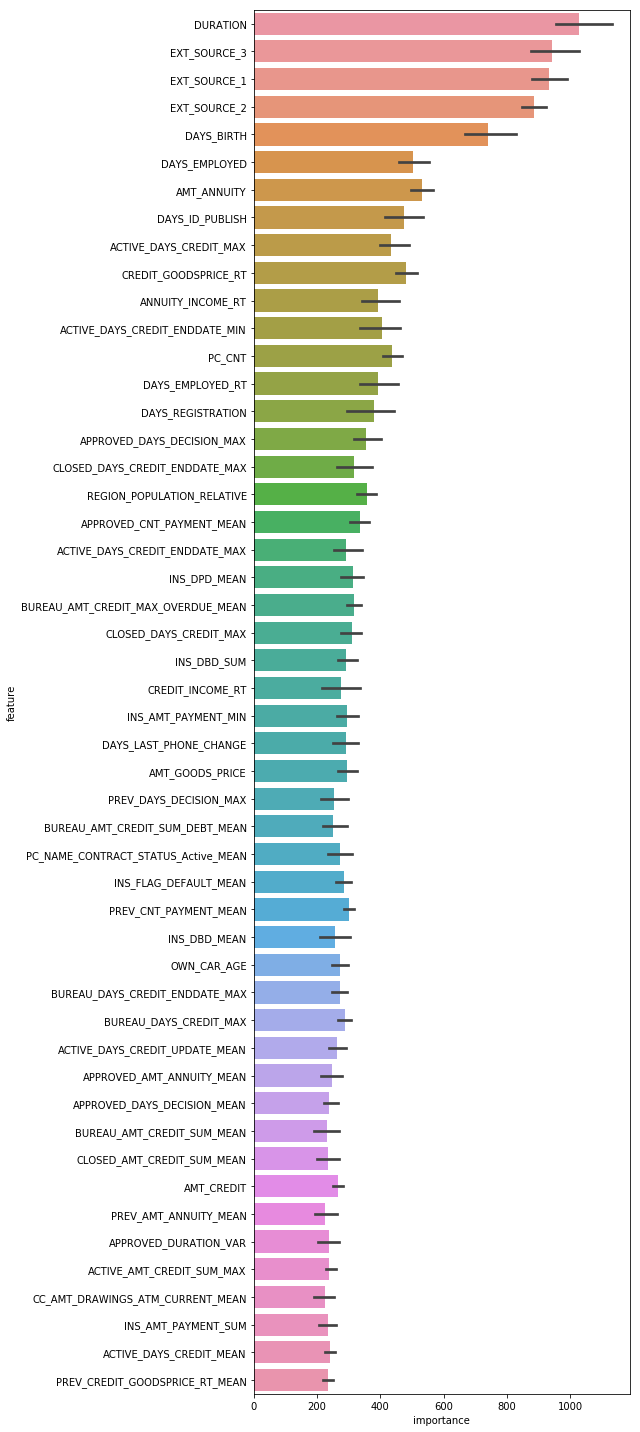

In [451]:
display_importances(lgb3_imp)

In [348]:
l1_train.head()

,lgb1_oof_train,lgb2_oof_train,lgb3_oof_train
0,0.287516,0.321982,0.312860
1,0.008720,0.009131,0.009659
2,0.035816,0.039811,0.029488
3,0.043703,0.039049,0.035219
4,0.062854,0.068985,0.064208


### Level 2 model - stacking with important features

In [362]:
# Keep features accounting for 80% of the importance in level 1 models
def norm_importance(df, threshold):
    df = df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    f_idx = np.min(np.where(df['cumulative_importance'] > threshold))
    f = list(df[:f_idx].index)
    return f

In [377]:
lgb1_f80 = norm_importance(lgb1_imp, 0.8)
lgb2_f80 = norm_importance(lgb2_imp, 0.8)
lgb3_f80 = norm_importance(lgb3_imp, 0.8)

f80 = list(set(lgb1_f80) & set(lgb2_f80) & set(lgb3_f80))

l2_train = pd.concat([train[f80], l1_train], axis=1)
l2_test = pd.concat([test[f80], l1_test], axis=1)

Fold 0
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.787736
[200]	valid_0's auc: 0.787858
[300]	valid_0's auc: 0.787948
[400]	valid_0's auc: 0.787981
[500]	valid_0's auc: 0.788039
[600]	valid_0's auc: 0.788166
[700]	valid_0's auc: 0.788224
[800]	valid_0's auc: 0.788176
Early stopping, best iteration is:
[690]	valid_0's auc: 0.788237
Fold 1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.789498
[200]	valid_0's auc: 0.789605
[300]	valid_0's auc: 0.789608
[400]	valid_0's auc: 0.789823
[500]	valid_0's auc: 0.789869
[600]	valid_0's auc: 0.789937
[700]	valid_0's auc: 0.789909
[800]	valid_0's auc: 0.789825
Early stopping, best iteration is:
[603]	valid_0's auc: 0.789945
Fold 2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.790758
[200]	valid_0's auc: 0.790764
[300]	valid_0's auc: 0.790867
[400]	valid_0's auc: 0.790937
[500]	valid_0's auc: 0.790827
Early stopping, best iteration

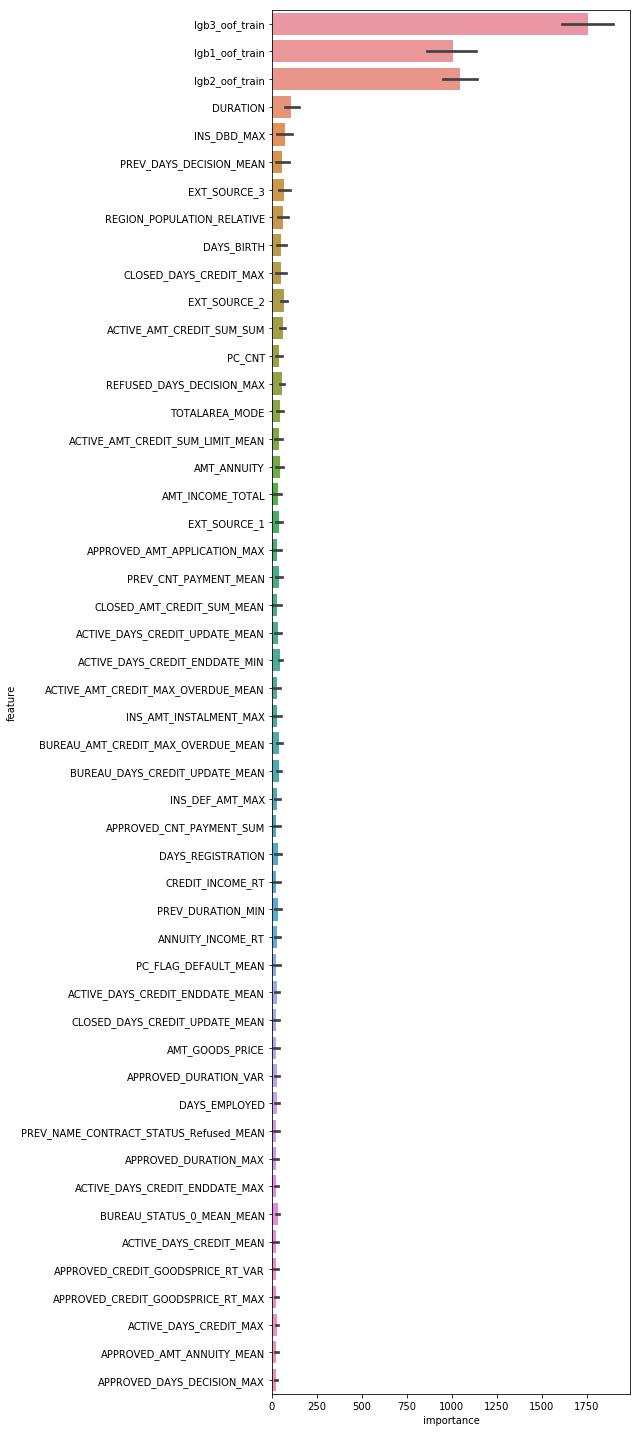

In [439]:
lgb_params_3={
'colsample_bytree': 0.8894802212274641,
'learning_rate': 0.005,
'num_leaves': 14,
'subsample': 0.8911908493254617,
'max_depth': 6,
'reg_alpha': 0.03381346813466218,
'reg_lambda': 0.06882890253277864,
'min_split_gain': 0.011217076187842845
}

ROUNDS=2000

feats_4 = l2_train.columns.tolist()

lgb5_oof = lgb.LGBMClassifier(**lgb_params_3, num_boost_round=ROUNDS)
lgb5_oof_train, lgb5_oof_test, lgb5_imp = get_oof_lgb(
    lgb5_oof, l2_train, target, l2_test, feats_4, display=True)


In [441]:
sub = test[['SK_ID_CURR', 'lgb5_oof_test']]
sub.columns = ['SK_ID_CURR', 'TARGET']
sub.to_csv('lgb5_oof_test.csv', index=False)

##### AUC score: 0.790